In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import style
style.use('ggplot')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Skill_Genie_DS_Intership/emails.csv')
data.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
data.shape

(5172, 3002)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Columns: 3002 entries, Email No. to Prediction
dtypes: int64(3001), object(1)
memory usage: 118.5+ MB


Text(0.5, 1.0, 'Emails distribution')

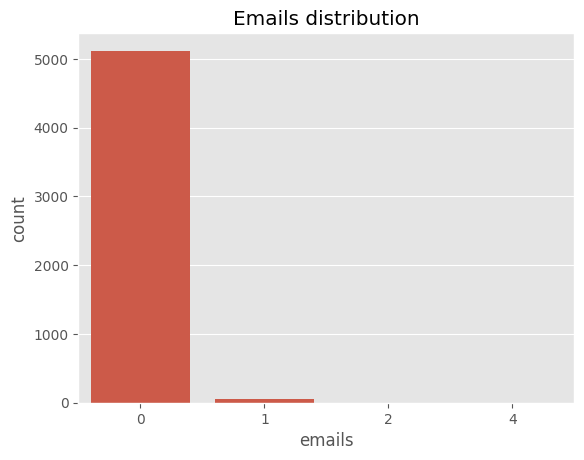

In [ ]:
sns.countplot(x='emails', data=data)
plt.title("Emails distribution")

In [ ]:
for i in range(5):
    print("Email: ", [i])
    print(data['Email No.'].iloc[i], "\n")
    print("Email: ", data['Prediction'].iloc[i], "\n\n")

Email:  [0]
Email 1 

Email:  0 


Email:  [1]
Email 2 

Email:  0 


Email:  [2]
Email 3 

Email:  0 


Email:  [3]
Email 4 

Email:  0 


Email:  [4]
Email 5 

Email:  0 




preprocessing

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer



# Remove irrelevant information from email text
def preprocess_text(text):
    text = BeautifulSoup(text, 'html.parser').get_text()  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = ' '.join(text.split())  # Remove extra whitespaces
    return text.lower()  # Convert to lowercase

data['processed_email'] = data['Email No.'].apply(preprocess_text)

# Tokenize, stem, and vectorize the text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_email'])


Feature Engineering

In [ ]:
# Extract features from email text (word frequency)
features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Additional features (e.g., email sender, subject line, attachment presence)
additional_features = data.drop(columns=['email', 'processed_email'])

# Convert non-numeric columns to numeric using one-hot encoding
additional_features_encoded = pd.get_dummies(additional_features)

# Combine word frequency features with additional features
X_combined = pd.concat([features, additional_features_encoded], axis=1)


In [ ]:
# Check class distribution
print(data['Prediction'].value_counts())


Prediction
0    3672
1    1500
Name: count, dtype: int64


In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = data[data['Prediction'] == 0]
minority_class = data[data['Prediction'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

# Combine majority class with upsampled minority class
balanced_data = pd.concat([majority_class, minority_upsampled])

# Use balanced_data for further processing


Data split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, data['Prediction'], test_size=0.2, random_state=42)


Model selection and training

In [ ]:

from sklearn.naive_bayes import MultinomialNB


# Train a Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

Model Evaluation

Naive Bayes

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.966183574879227
Precision: 0.8942598187311178
Recall: 1.0
F1 Score: 0.9441786283891547


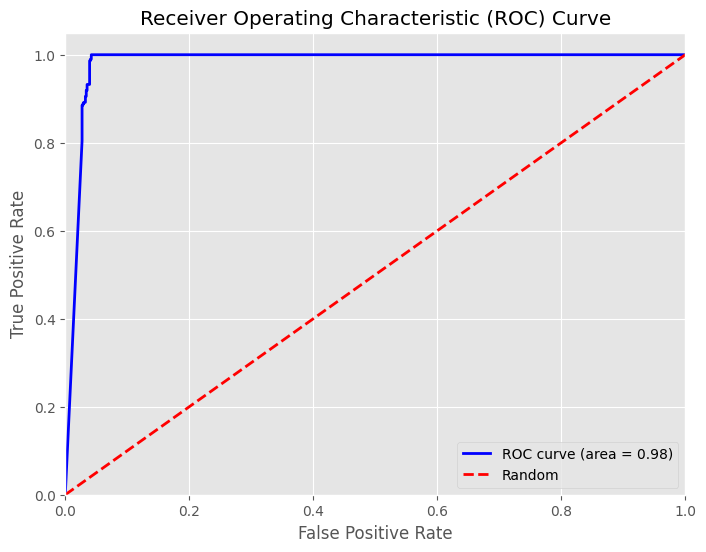

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f'Logistic Regression Model - Accuracy: {accuracy_lr}, Precision: {precision_lr}, Recall: {recall_lr}, F1 Score: {f1_lr}')


Logistic Regression Model - Accuracy: 0.9932367149758454, Precision: 0.9865319865319865, Recall: 0.9898648648648649, F1 Score: 0.9881956155143339


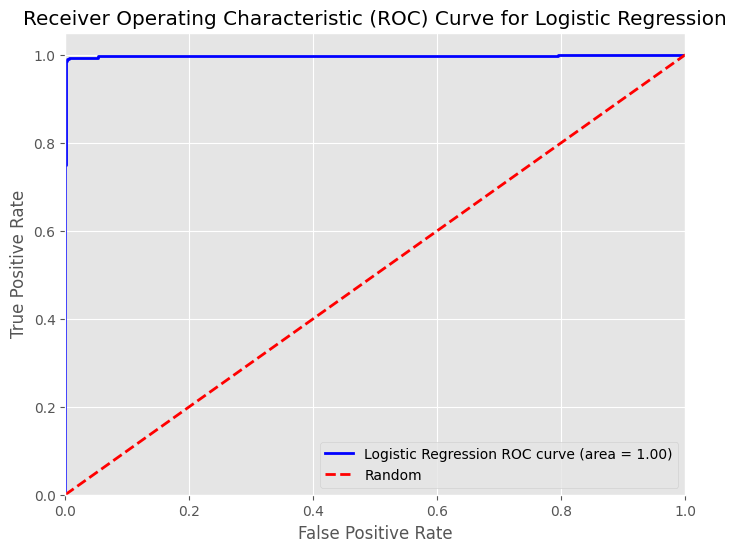

In [ ]:
# Get predicted probabilities for positive class
y_probs_lr = lr_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_probs_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve for Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()


SVM

In [ ]:
from sklearn.svm import SVC

# Train an SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Calculate evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f'SVM Model - Accuracy: {accuracy_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1 Score: {f1_svm}')


SVM Model - Accuracy: 0.9971014492753624, Precision: 0.9932659932659933, Recall: 0.9966216216216216, F1 Score: 0.9949409780775715


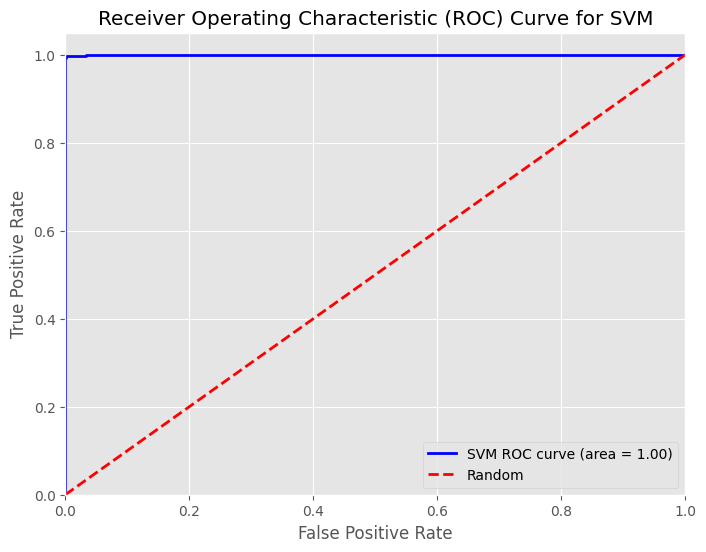

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for positive class
y_probs_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_probs_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve for SVM
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='SVM ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate Naive Bayes model
accuracy_nb = accuracy_score(y_test, y_pred)
precision_nb = precision_score(y_test, y_pred)
recall_nb = recall_score(y_test, y_pred)
f1_nb = f1_score(y_test, y_pred)
roc_auc_nb = roc_auc_score(y_test, y_probs)

print("Naive Bayes Model -")
print(f"Accuracy: {accuracy_nb}, Precision: {precision_nb}, Recall: {recall_nb}, F1 Score: {f1_nb}, ROC AUC: {roc_auc_nb}")

# Evaluate SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_probs_svm)

print("\nSupport Vector Machine (SVM) Model -")
print(f"Accuracy: {accuracy_svm}, Precision: {precision_svm}, Recall: {recall_svm}, F1 Score: {f1_svm}, ROC AUC: {roc_auc_svm}")

# Evaluate Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_probs_lr)

print("\nLogistic Regression Model -")
print(f"Accuracy: {accuracy_lr}, Precision: {precision_lr}, Recall: {recall_lr}, F1 Score: {f1_lr}, ROC AUC: {roc_auc_lr}")

# Compare models
models = ['Naive Bayes', 'SVM', 'Logistic Regression']
accuracies = [accuracy_nb, accuracy_svm, accuracy_lr]
precisions = [precision_nb, precision_svm, precision_lr]
recalls = [recall_nb, recall_svm, recall_lr]
f1_scores = [f1_nb, f1_svm, f1_lr]
roc_aucs = [roc_auc_nb, roc_auc_svm, roc_auc_lr]

# Find the best performing model based on F1 score
best_model_idx = f1_scores.index(max(f1_scores))
best_model = models[best_model_idx]
print(f"\nThe best performing model based on F1 score is: {best_model}")


Naive Bayes Model -
Accuracy: 0.966183574879227, Precision: 0.8942598187311178, Recall: 1.0, F1 Score: 0.9441786283891547, ROC AUC: 0.9826738104816589

Support Vector Machine (SVM) Model -
Accuracy: 0.9971014492753624, Precision: 0.9932659932659933, Recall: 0.9966216216216216, F1 Score: 0.9949409780775715, ROC AUC: 0.9998811395969719

Logistic Regression Model -
Accuracy: 0.9932367149758454, Precision: 0.9865319865319865, Recall: 0.9898648648648649, F1 Score: 0.9881956155143339, ROC AUC: 0.9967907691182388

The best performing model based on F1 score is: SVM
